In [366]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
import scipy.stats

# Gillespie Simulation

In [585]:
global N_total                      #Definición global de la variable
N_total = 100                       #Cantidad de nodos libres (indicadores de salud) en una persona
tiempo_vida_maximo = 200            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
alpha_damage_propagation = 0.062    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-4))     #Tasa de mortalidad

disease_rate = 0.04                 #Tasa de enfermedades NUESTRO INTERES

@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1

        else: 
            died = True

        t+=τ
    return np.array([t,N, died]) 

@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):

    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
        if X[i][2]:
            break
    return X

# Initial conditions

In [586]:
x0 = np.array([0., 0., False])
num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,2.)) for i in tqdm(range(num_cel))])

100%|██████████| 100000/100000 [00:03<00:00, 32849.13it/s]


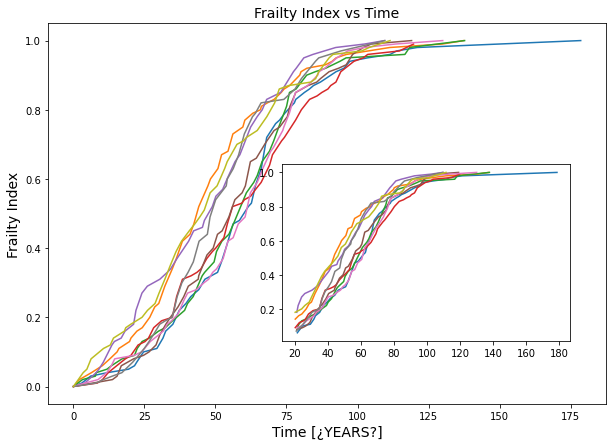

In [457]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
zoom_region = [0.45, 0.25, 0.4, 0.35]

fig, ax = plt.subplots(figsize = (10,7))
ax_zoom = plt.axes(zoom_region)
for i in range(1,10):
    indice = np.argmax(celulas[i][:, 2] == 1)
    ax.plot(celulas[i][:indice][:,0], celulas[i][:indice][:,1]/N_total)
    ax_zoom.plot(celulas[i][10:indice][:,0], celulas[i][10:indice][:,1]/N_total)
ax.set_xlabel("Time [¿YEARS?]", fontsize = 14)
ax.set_ylabel("Frailty Index", fontsize = 14)
ax.set_title("Frailty Index vs Time", fontsize = 14)
#plt.savefig("Gillespie_patterns.jpg", dpi = 500)
plt.show()


# Average Frailty Behaviour

In [588]:
rango_edades = np.arange(0, 150, 1)
behaviour_frailty = np.empty_like(rango_edades, dtype=object)

for idx, edad in enumerate(tqdm(rango_edades)):
    rango_min = edad - 0.25
    rango_max = edad + 0.25
    celulas_divided = celulas[:, :, 0]
    
    indices = np.logical_and(celulas_divided >= rango_min, celulas_divided <= rango_max)
    valores = celulas[indices, 1] 
    behaviour_frailty[idx] = valores

100%|██████████| 150/150 [00:08<00:00, 18.23it/s]


In [497]:
frailty_average = np.empty_like(rango_edades, dtype=float)
for i in range(len(behaviour_frailty)):
    promedio = np.mean(behaviour_frailty[i])
    frailty_average[i] = promedio

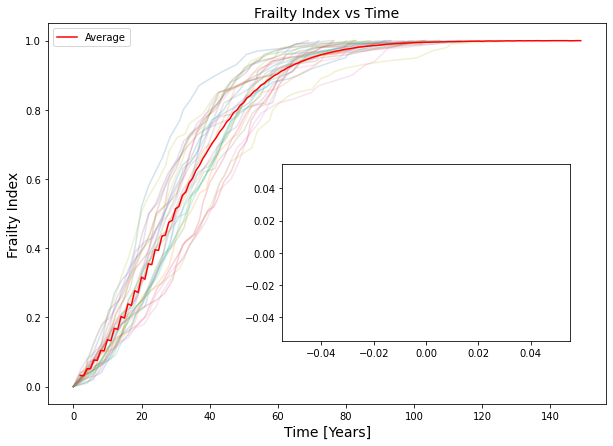

In [181]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
zoom_region = [0.45, 0.25, 0.4, 0.35]

fig, ax = plt.subplots(figsize = (10,7))
ax_zoom = plt.axes(zoom_region)
for i in range(1,30):
    indice = np.argmax(celulas[i][:, 2] == 1)
    ax.plot(celulas[i][:indice][:,0], celulas[i][:indice][:,1]/N_total, alpha = 0.2)
    ax_zoom.plot(celulas[i][2000:indice][:,0]/100, celulas[i][2000:indice][:,1]/100, alpha = 0.2)
ax.plot(frailty_average/N_total, color = "red", label = "Average")
ax_zoom.plot(frailty_average[1000:-1], color = "red")
ax.set_xlabel("Time [Years]", fontsize = 14)
ax.set_ylabel("Frailty Index", fontsize = 14)
ax.set_title("Frailty Index vs Time", fontsize = 14)
ax.legend()
#plt.savefig("Gillespie_patterns.jpg", dpi = 500)
plt.show()


# Frailty Index distribution

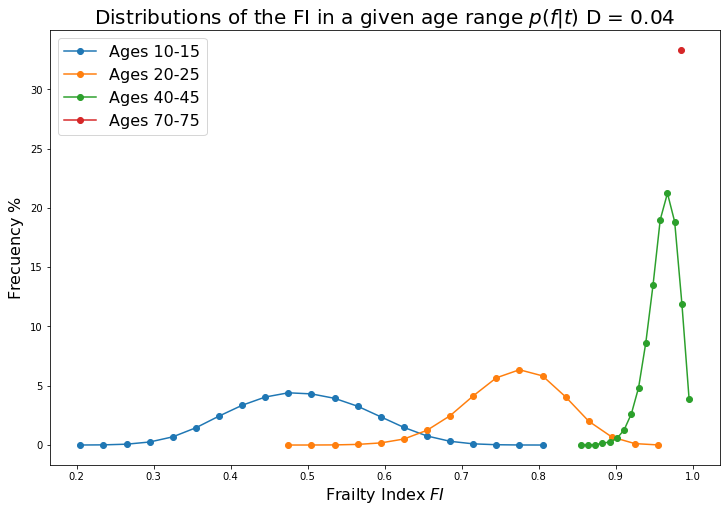

In [636]:
import matplotlib.pyplot as plt
import numpy as np
datos_10_15 = np.concatenate((behaviour_frailty[10:15]))
datos_40_45 = np.concatenate((behaviour_frailty[40:45]))
datos_60_65 = np.concatenate((behaviour_frailty[20:25]))
datos_70_75 = np.concatenate((behaviour_frailty[70:75]))

hist_a, bins_a, = np.histogram(datos_10_15, density=True, bins = 21)  # Utiliza la opción density=True
hist_b, bins_b, = np.histogram(datos_40_45, density=True, bins = 16)  # Utiliza la opción density=True
hist_c, bins_c, = np.histogram(datos_60_65, density=True, bins = 17)  # Utiliza la opción density=True
hist_d, bins_d, = np.histogram(datos_70_75, density=True, bins = 1)  # Utiliza la opción density=True

max_points_a = bins_a[:-1] + np.diff(bins_a) / 2
max_points_b = bins_b[:-1] + np.diff(bins_b) / 2
max_points_c = bins_c[:-1] + np.diff(bins_c) / 2
max_points_d = bins_d[:-1] + np.diff(bins_d) / 2

max_points_filtered_a = max_points_a[hist_a > 0]
max_points_filtered_b = max_points_b[hist_b > 0]
max_points_filtered_c = max_points_c[hist_c > 0]
max_points_filtered_d = max_points_d[hist_d > 0]

hist_filtered_a = hist_a[hist_a > 0]
hist_filtered_b = hist_b[hist_b > 0]
hist_filtered_c = hist_c[hist_c > 0]
hist_filtered_d = hist_d[hist_d > 0]

plt.figure(figsize=(12,8))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ D = 0.04", fontsize = 20)
plt.plot(max_points_filtered_a/100, hist_filtered_a*100, marker='o', label = "Ages 10-15")
plt.plot(max_points_filtered_c/100, hist_filtered_c*100, marker='o', label = "Ages 20-25")
plt.plot(max_points_filtered_b/100, hist_filtered_b*100, marker='o', label = "Ages 40-45")
plt.plot(max_points_filtered_d/100, hist_filtered_d*100, marker='o', label = "Ages 70-75")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
#plt.savefig("Distribution_frailty_disease_rate_004.jpg", dpi = 500)
plt.show()

# Doone's Equation

In [590]:
cantidad_datos_10_15 = len(datos_10_15)
S_10_15 = scipy.stats.skew(datos_10_15)
number_of_bins_a = 1 + np.log2(cantidad_datos_10_15) + np.log2(1 + np.sqrt(((cantidad_datos_10_15+1)*(cantidad_datos_10_15+3))/(6*(cantidad_datos_10_15-2)))*np.abs(S_10_15))

cantidad_datos_40_45 = len(datos_40_45)
S_10_15 = scipy.stats.skew(datos_40_45)
number_of_bins_b = 1 + np.log2(cantidad_datos_10_15) + np.log2(1 + np.sqrt(((cantidad_datos_10_15+1)*(cantidad_datos_10_15+3))/(6*(cantidad_datos_10_15-2)))*np.abs(S_10_15))

cantidad_datos_60_65 = len(datos_60_65)
S_10_15 = scipy.stats.skew(datos_60_65)
number_of_bins_c = 1 + np.log2(cantidad_datos_10_15) + np.log2(1 + np.sqrt(((cantidad_datos_10_15+1)*(cantidad_datos_10_15+3))/(6*(cantidad_datos_10_15-2)))*np.abs(S_10_15))

cantidad_datos_70_75 = len(datos_70_75)
S_10_15 = scipy.stats.skew(datos_70_75)
number_of_bins_d = 1 + np.log2(cantidad_datos_10_15) + np.log2(1 + np.sqrt(((cantidad_datos_10_15+1)*(cantidad_datos_10_15+3))/(6*(cantidad_datos_10_15-2)))*np.abs(S_10_15))


In [591]:
print(number_of_bins_a)
print(number_of_bins_b)
print(number_of_bins_c)
print(number_of_bins_d)

21.744244970886577
25.47707220698015
24.04298791460822
27.167488151140944


(array([6.72315435e-05, 8.96420579e-05, 3.92184004e-04, 1.52391499e-03,
        2.79010905e-03, 5.88276005e-03, 1.36255928e-02, 2.79010905e-02,
        0.00000000e+00, 5.13536939e-02, 9.15693622e-02, 1.43124751e-01,
        2.01851504e-01, 2.25539418e-01, 2.00036252e-01, 1.26641817e-01,
        4.09440100e-02]),
 array([ 85.        ,  85.88235294,  86.76470588,  87.64705882,
         88.52941176,  89.41176471,  90.29411765,  91.17647059,
         92.05882353,  92.94117647,  93.82352941,  94.70588235,
         95.58823529,  96.47058824,  97.35294118,  98.23529412,
         99.11764706, 100.        ]),
 <BarContainer object of 17 artists>)

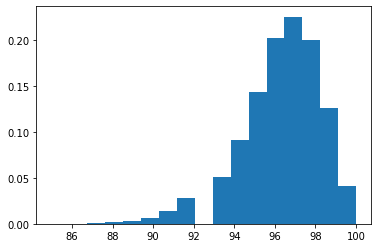

In [648]:
plt.hist(datos_40_45, density=True, bins =17)

# Average Death Behaviour

In [183]:
rango_edades = np.arange(1, 150, 1)
death_behaviour = np.empty_like(rango_edades, dtype=object)

for idx, edad in enumerate(tqdm(rango_edades)):
    rango_min = edad - 0.25
    rango_max = edad + 0.25

    indices = np.where((celulas[:, :, 2]  == 1.0))
    valores = celulas[indices[0], indices[1], 1]
    death_behaviour[idx] = valores

100%|██████████| 149/149 [00:17<00:00,  8.66it/s]


In [ ]:
plt.figure(figsize=(10,7))
plt.hist(muerte[0], density = True, bins = 20)

In [ ]:
informacion_20 = np.concatenate((behaviour_frailty[5:10]))
informacion_40 = np.concatenate((behaviour_frailty[40:45]))
informacion_60 = np.concatenate((behaviour_frailty[60:65]))

plt.figure(figsize=(15,12))
plt.hist(informacion_20, density=True, bins =10, label = "5-10 ¿years?")
plt.hist(informacion_40, density=True, bins = 10, label = "40-45 ¿years?")
plt.hist(informacion_60, density=True, bins = 10, label = "60-65 ¿years?")
plt.legend()
#plt.hist(informacion_100, density=True)

In [ ]:
hist_1, bins_1 = np.histogram(np.concatenate((behaviour_frailty[20:25]/100)), density=True)
hist_2, bins_2 = np.histogram(np.concatenate((behaviour_frailty[60:65]/100)), density=True)
hist_3, bins_3 = np.histogram(np.concatenate((behaviour_frailty[80:85]/100)), density=True)
hist_4, bins_4 = np.histogram(np.concatenate((behaviour_frailty[45:50]/100)), density=True)


# Obtener los puntos medios de cada bin
bin_centers_1 = 0.5 * (bins_1[:-1] + bins_1[1:])
bin_centers_2 = 0.5 * (bins_2[:-1] + bins_2[1:])
bin_centers_3 = 0.5 * (bins_3[:-1] + bins_3[1:])
bin_centers_4 = 0.5 * (bins_4[:-1] + bins_4[1:])

# Visualizar el histograma como una línea
plt.figure(figsize=(11,8))
plt.plot(bin_centers_1, hist_1, '-', color = "red")
plt.plot(bin_centers_2, hist_2, '-', color = "orange")
#plt.plot(bin_centers_3, hist_3, '-', color = "green")
plt.plot(bin_centers_4, hist_4, '-', color = "violet")

#plt.scatter(bin_centers, hist )
plt.xlabel('Years')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.show()

In [ ]:
plt.hist(np.concatenate((behaviour_frailty[60:65]/100)), density=True, bins = 10)